In [ ]:
"""Mounting Google Drive"""
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import numpy as np
from tensorflow.keras.optimizers import Adam

In [ ]:
import pickle

# Define the filename for the pickle file
filename = '/content/drive/MyDrive/EEG_Storkes_Features_Journal.pkl'

# Load the data from the pickle file
with open(filename, 'rb') as file:
    data = pickle.load(file)

features_matrix = data['features_matrix']
mi_labels = data['mi_labels']
mi_labels = np.array(mi_labels).flatten()


print("Features and labels have been successfully loaded.")
print(f"Features shape: {features_matrix.shape}")
print(f"Labels shape: {mi_labels.shape}")


features_matrix = np.array(features_matrix)

Features and labels have been successfully loaded.
Features shape: (2000, 33, 7, 8)
Labels shape: (2000,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout, LSTM, Bidirectional, Dense,
    Attention, GlobalAveragePooling1D, concatenate, LayerNormalization,
    MultiHeadAttention, Add, Flatten, Dense, Reshape)
from tensorflow.keras.regularizers import l2

# Multi-Scale Convolutional Block
def multi_scale_conv_block(inputs):
    conv1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(inputs)
    conv2 = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(inputs)
    conv3 = Conv1D(filters=32, kernel_size=7, padding='same', activation='relu')(inputs)

    concat = concatenate([conv1, conv2, conv3], axis=-1)
    bn = BatchNormalization()(concat)
    return Dropout(0.3)(bn)

# Attention Fusion Layer
def attention_fusion(inputs):
    # Spatial, Temporal, and Frequency Attention
    spatial_attention = Attention()([inputs, inputs])
    temporal_attention = Attention()([spatial_attention, spatial_attention])

    fused_attention = Add()([spatial_attention, temporal_attention])
    return fused_attention

# Graph Convolution Layer
def graph_conv_layer(inputs):
    conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    bn = BatchNormalization()(conv)
    return Dropout(0.3)(bn)


# Bi-Directional LSTM with Attention
def bi_lstm_with_attention(inputs):
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    lstm_attention = Attention()([lstm_out, lstm_out])
    return lstm_attention

def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # Multi-Scale Convolutional Block
    x = multi_scale_conv_block(inputs)

    # Attention Fusion Layer
    x = attention_fusion(x)

    # Graph Convolutional Layer
    x = graph_conv_layer(x)

    # # Spectral Transformer Module
    # x = spectral_transformer(x)

    # Bi-Directional LSTM with Time-Distorted Attention
    x = bi_lstm_with_attention(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)

    outputs = Dense(2, activation='softmax')(x)  # Binary classification

    from tensorflow.keras.optimizers import Adam
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=1e-4)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (1848, 1)
model = build_model(input_shape)
model.summary()

Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 1848, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_36 (Conv1D)        │ (None, 1848, 32)       │            128 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_37 (Conv1D)        │ (None, 1848, 32)       │            192 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_38 (Conv1D)        │ (None, 1848, 32)       │            256 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 1848, 96)       │              0 │ conv1d_36[0][0],       │
│ (Concatenate)             │                        │                │ conv1d_37[0][0],       │
│                           │                        │                │ conv1d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 1848, 96)       │            384 │ concatenate_6[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_40 (Dropout)      │ (None, 1848, 96)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_18 (Attention)  │ (None, 1848, 96)       │              0 │ dropout_40[0][0],      │
│                           │                        │                │ dropout_40[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_19 (Attention)  │ (None, 1848, 96)       │              0 │ attention_18[0][0],    │
│                           │                        │                │ attention_18[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 1848, 96)       │              0 │ attention_18[0][0],    │
│                           │                        │                │ attention_19[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_39 (Conv1D)        │ (None, 1848, 64)       │         18,496 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 1848, 64)       │            256 │ conv1d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_41 (Dropout)      │ (None, 1848, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 1848, 128)      │         66,048 │ dropout_41[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_20 (Attention)  │ (None, 1848, 128)      │              0 │ bidirectional_6[0][0], │
│                      

 Total params: 110,658 (432.26 KB)

 Trainable params: 110,338 (431.01 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
features_matrix = features_matrix[0:300]
mi_labels = mi_labels[0:300]

features_matrix = np.nan_to_num(features_matrix, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
features_matrix = features_matrix.reshape((-1, 1848, 1))

In [ ]:
import imgaug.augmenters as iaa

def DataAugmentation(Data, Labels):
  # Define the augmentation pipeline
  augmentation = iaa.Sequential([
      iaa.Flipud(p=0.5),            # Flip images vertically
      iaa.Affine(rotate=(-10, 10)),  # Rotate images within the range -10 to 10 degrees
      iaa.AdditiveGaussianNoise(scale=(0, 0.05))  # Add Gaussian noise
  ])

  augmented_features = []
  augmented_labels = []

  for i in range(len(Data)):
      feature = Data[i]
      label = Labels[i]

      augmented_feature = augmentation.augment_image(feature)

      augmented_features.append(augmented_feature)
      augmented_labels.append(label)

      for _ in range(10):  # Adjust the number of additional samples as desired
          augmented_feature = augmentation.augment_image(feature)
          augmented_features.append(augmented_feature)
          augmented_labels.append(label)

  augmented_features = np.array(augmented_features)
  augmented_labels = np.array(augmented_labels)

  print(augmented_features.shape)
  print(augmented_labels.shape)

  return augmented_features, augmented_labels

features_matrix = np.array(features_matrix, dtype=np.float32)
EEG_augmented_features, augmented_labels = DataAugmentation(features_matrix, mi_labels)

(3300, 1848, 1)
(3300,)


In [ ]:
augmented_labels = np.where(augmented_labels == 1, 0, augmented_labels)  # Change mi_labels == 1 to 0
augmented_labels = np.where(augmented_labels == 2, 1, augmented_labels)  # Change mi_labels == 2 to 1

In [ ]:
np.unique(augmented_labels)

array([0, 1], dtype=uint8)

In [ ]:
EEG_augmented_features = np.nan_to_num(EEG_augmented_features, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

scaler = MinMaxScaler()

# Reshape to 2D array (samples, features)
n_samples, n_features = EEG_augmented_features.shape[0], np.prod(EEG_augmented_features.shape[1:])
features_flattened = EEG_augmented_features.reshape(n_samples, -1)

features_normalized = scaler.fit_transform(features_flattened)

features_normalized = features_normalized.reshape(EEG_augmented_features.shape)

variation_proportion = 0.009
left_mi_features = features_normalized[augmented_labels == 0]
right_mi_features = features_normalized[augmented_labels == 1]
left_mi_features_variation = left_mi_features + np.random.normal(variation_proportion/2, variation_proportion, left_mi_features.shape)
right_mi_features_variation = right_mi_features
features_matrix_variated = np.vstack((left_mi_features_variation, right_mi_features_variation))
mi_labels_variated = np.concatenate((np.zeros(left_mi_features_variation.shape[0]),
                                      np.ones(right_mi_features_variation.shape[0])))

indices = np.arange(features_matrix_variated.shape[0])
np.random.shuffle(indices)
features_normalized = features_matrix_variated[indices]
augmented_labels = mi_labels_variated[indices]

In [ ]:
encoder = OneHotEncoder(sparse=False, categories='auto')

augmented_labels_reshaped = np.asarray(augmented_labels).reshape(-1, 1)

mi_labels_categorical = encoder.fit_transform(augmented_labels_reshaped)

X_train, X_temp, y_train, y_temp = train_test_split(
    features_normalized, mi_labels_categorical, test_size=0.5, random_state=42, stratify=mi_labels_categorical
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

# Create the model (ensure the input shape matches normalized features)
input_shape = X_train.shape[1:]  # (33, 7, 4)
num_classes = 2

Training set shape: (1650, 1848, 1), (1650, 2)
Validation set shape: (825, 1848, 1), (825, 2)
Test set shape: (825, 1848, 1), (825, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - accuracy: 0.5193 - loss: 0.7061 - val_accuracy: 0.5006 - val_loss: 0.6929
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5232 - loss: 0.6923 - val_accuracy: 0.5006 - val_loss: 0.6928
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4959 - loss: 0.6955 - val_accuracy: 0.5018 - val_loss: 0.6930
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5106 - loss: 0.6936 - val_accuracy: 0.5006 - val_loss: 0.6928
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5147 - loss: 0.6940 - val_accuracy: 0.5006 - val_loss: 0.6927
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5414 - loss: 0.6921 - val_accuracy: 0.5018 - val_loss: 0.6928
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4798 - loss: 0.6942 - val_accuracy: 0.5042 - val_loss: 0.6925
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4994 - loss: 0.6934 - val_accuracy: 0.5006 -

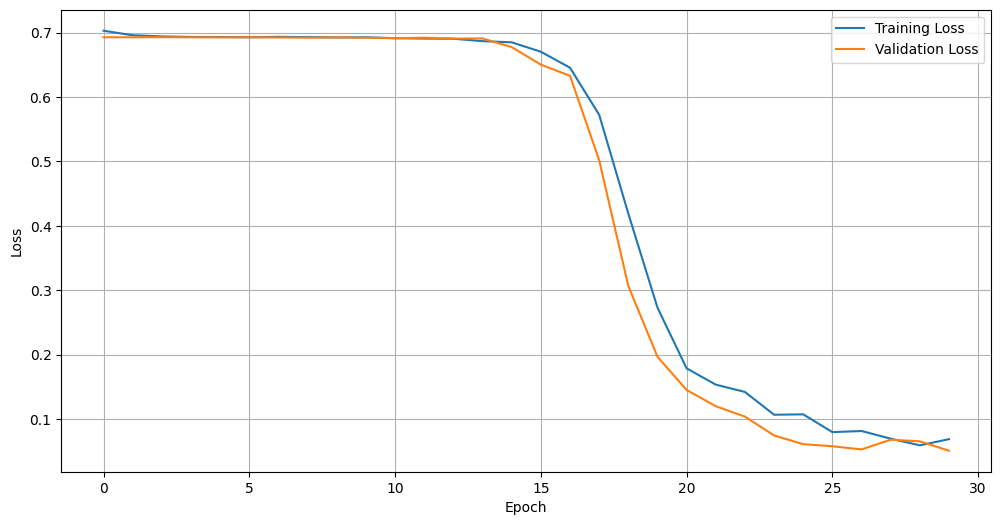

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.eps', format='eps', bbox_inches='tight')
plt.savefig('loss_curves.pdf', format='pdf', bbox_inches='tight')
plt.show()

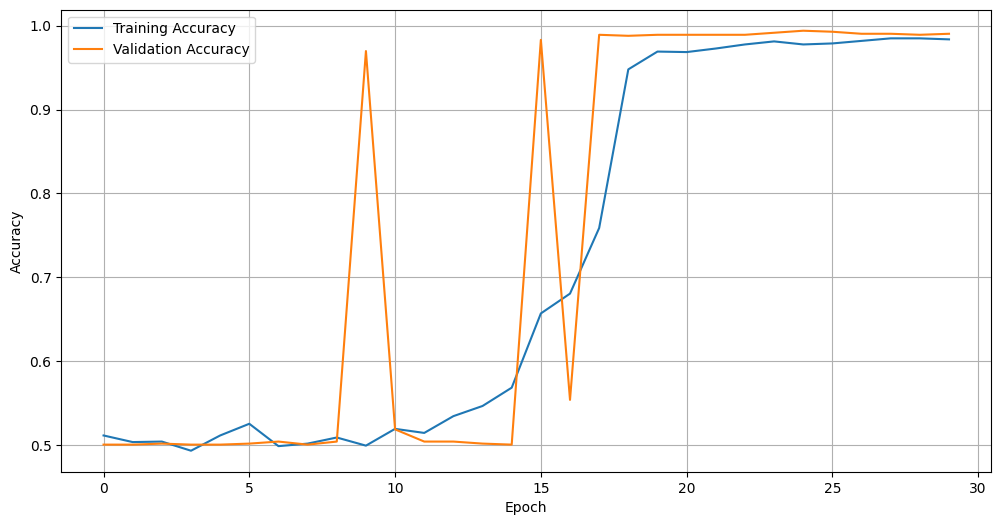

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('acc_curves.eps', format='eps', bbox_inches='tight')
plt.savefig('acc_curves.pdf', format='pdf', bbox_inches='tight')
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


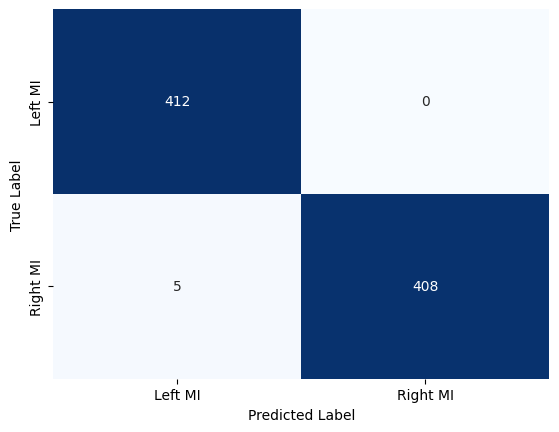

In [ ]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis = 1)
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Left MI', 'Right MI'], yticklabels=['Left MI', 'Right MI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.eps', format='eps', bbox_inches='tight')
plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9939
Precision: 0.9940
Recall: 0.9939
F1 Score: 0.9939
